#Init Colab

In [1]:
!nvidia-smi

Fri Apr 15 10:19:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     37MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Init

In [2]:
## for data
import os
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for model 
import torch
import torch.nn as nn

##Other
import time
import random
import json
from typing import Dict
from torch.utils.data import Dataset, DataLoader
import itertools
import torch_scatter as pysc

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already u

ModuleNotFoundError: No module named 'torch_scatter'

In [3]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
gensim_vocab_name = "glove-wiki-gigaword-300"

In [5]:
loaded_word_vocab = gensim.downloader.load(gensim_vocab_name)

In [6]:
def seed_all(seed: int = 42):
    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
seed_all()

[ Using Seed :  42  ]


In [ ]:
temp_path = "../../"
data_path = os.path.join(temp_path, "data")
model_p = os.path.join(temp_path, "model")
train_path = os.path.join(data_path, "train.tsv")
dev_path = os.path.join(data_path, "dev.tsv")

In [9]:
from typing import List, Tuple

def read_dataset(path: str) -> Tuple[List[List[str]], List[List[str]]]:
    tokens_s = []
    labels_s = []

    tokens = []
    labels = []

    with open(path, encoding="utf-8") as f:

        for line in f:

            line = line.strip()

            if line.startswith("#\t"):
                tokens = []
                labels = []
            elif line == "":
                tokens_s.append(tokens)
                labels_s.append(labels)
            else:
                token, label = line.split("\t")
                tokens.append(token)
                labels.append(label)

    assert len(tokens_s) == len(labels_s)

    return tokens_s, labels_s

# WordClassificationDataset

In [276]:
class StudDataset(Dataset):

    def __init__(self,
                 tokens,
                 vocab,
                 pos_vocab,
                 char_vocab,
                 labels=None,
                 sw_filter=False,
                 lemming=False,
                 lowercase=False,
                 max_len=-1,
                 device="cpu"):

        if labels is None:
            labels = []
        self.lowercase = lowercase
        self.lemming = lemming
        self.sw_filter = sw_filter
        self.device = device
        self.encoded_data = []
        self.vocab = vocab
        self.pos_vocab = pos_vocab
        self.char_vocab = char_vocab
        self.init_structures(tokens, labels, max_len)
        self.words_pad = self.vocab["<PAD>"]
        self.char_pad = self.char_vocab["<PAD>"]
        self.pos_pad = self.pos_vocab["<PAD>"]
        self.label_pad = self.encode_class("<PAD>")


    def init_structures(self, s_tokens, s_labels, max_len) -> None:
        unk_count_d = 0
        for index_s, tokenized_s in enumerate(s_tokens):

            words_posses = nltk.pos_tag(tokenized_s, tagset='universal')

            words_idx, pos_idx, char_idx, words_len, unk_count_s = self.index_words(words_posses, max_len)
            unk_count_d += unk_count_s
            if len(s_labels) > 0:
                labels_idx = [StudDataset.encode_class(label) for label in s_labels[index_s]]
            else:
                labels_idx = []
            words_idx = torch.tensor(words_idx)
            pos_idx = torch.tensor(pos_idx)
            labels_idx = torch.tensor(labels_idx)
            char_idx = torch.tensor(char_idx)
            words_len = torch.tensor(words_len)
            self.encoded_data.append(
                ({'words_indx': words_idx, 'poses_indx': pos_idx, 'chars_indx': (char_idx, words_len)}, labels_idx,
                 index_s))
        print("{} unknown words found".format(unk_count_d))


    def index_words(self, words: List[Tuple], max_len: int):
        unk_count = 0
        idxs = []
        pos_idxs = []
        char_word_idxs = []
        words_indexes = []
        lemmatizer = WordNetLemmatizer()

        for i, (word, pos) in enumerate(words):
            if len(idxs) == max_len: break

            if self.lemming: word = lemmatizer.lemmatize(word, pos=self.get_wordnet_pos(pos))

            if word in self.vocab.keys():
                idxs.append(self.vocab[word])
            else:
                idxs.append(self.vocab["<UNK>"])
                unk_count += 1
            pos_idxs.append(self.pos_vocab.get(pos, self.pos_vocab.get('<UNK>')))

            for char in word:
                char_word_idxs.append(self.char_vocab.get(char, self.char_vocab.get("<UNK>")))
            words_indexes += [i]*len(word)

        return idxs, pos_idxs, char_word_idxs, words_indexes, unk_count

    @staticmethod
    def decode_class(index):
        if index == StudDataset.encode_class("<PAD>"): return "O"
        for ind, val in StudDataset.get_class_labels():
            if ind == index:
                return val

    @staticmethod
    def encode_class(label):
        for ind, val in StudDataset.get_class_labels():
            if val == label:
                return ind

    @staticmethod
    def get_class_labels() -> List:
        return [
            (0, "B-CORP"),
            (1, "B-CW"),
            (2, "B-GRP"),
            (3, "B-LOC"),
            (4, "B-PER"),
            (5, "B-PROD"),
            (6, "I-CORP"),
            (7, "I-CW"),
            (8, "I-GRP"),
            (9, "I-LOC"),
            (10, "I-PER"),
            (11, "I-PROD"),
            (12, "O"),
            (13, "<PAD>")
        ]

    @staticmethod
    def get_wordnet_pos(treebank_tag):

        if treebank_tag.startswith('ADJ'):
            return wordnet.ADJ
        elif treebank_tag.startswith('VERB'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('ADV'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.encoded_data)

    def getData(self):
        return self.encoded_data

    def __getitem__(self, idx):
        return self.encoded_data[idx]

    def collate_fn(self, data):
        words,posses,chars,scattered_chars,ys= [],[],[],[],[]
        for e in data:
            words.append(e[0]["words_indx"])
            posses.append(e[0]["poses_indx"])
            chars.append(e[0]["chars_indx"][0])
            scattered_chars.append(e[0]["chars_indx"][1])
            ys.append(e[1])

        words = torch.nn.utils.rnn.pad_sequence(words, padding_value=self.words_pad, batch_first=True)
        posses = torch.nn.utils.rnn.pad_sequence(posses, padding_value=self.pos_pad, batch_first=True)
        chars = torch.nn.utils.rnn.pad_sequence(chars, padding_value=self.char_pad, batch_first=True)
        scattered_chars = torch.nn.utils.rnn.pad_sequence(scattered_chars, padding_value=-1, batch_first=True)

        #NOT THE BEST
        #mx, _ = torch.max(scattered_chars, dim=1)
        scattered_chars[scattered_chars==-1] = torch.max(scattered_chars)+1

        ys = torch.nn.utils.rnn.pad_sequence(ys, padding_value=self.label_pad, batch_first=True)
        mask = words != self.vocab["<PAD>"]

        return {"words": words, "poses": posses, "chars":chars, "mask":mask, "scattered":scattered_chars}, {"labels": ys}

In [277]:
class StudDataset_CoNLL(Dataset):

    def __init__(self,
                 tokens,
                 vocab,
                 pos_vocab,
                 char_vocab,
                 labels=None,
                 sw_filter=False,
                 lemming=False,
                 lowercase=False,
                 max_len=-1,
                 device="cpu"):

        if labels is None:
            labels = []
        self.lowercase = lowercase
        self.lemming = lemming
        self.sw_filter = sw_filter
        self.device = device
        self.encoded_data = []
        self.vocab = vocab
        self.pos_vocab = pos_vocab
        self.char_vocab = char_vocab
        self.init_structures(tokens, labels, max_len)
        self.words_pad = self.vocab["<PAD>"]
        self.char_pad = self.char_vocab["<PAD>"]
        self.pos_pad = self.pos_vocab["<PAD>"]
        self.label_pad = self.encode_class("<PAD>")


    def init_structures(self, s_tokens, s_labels, max_len) -> None:
        unk_count_d = 0
        for index_s, tokenized_s in enumerate(s_tokens):

            words_posses = nltk.pos_tag(tokenized_s, tagset='universal')

            words_idx, pos_idx, char_idx, words_len, unk_count_s = self.index_words(words_posses, max_len)
            unk_count_d += unk_count_s
            if len(s_labels) > 0:
                labels_idx = [StudDataset_CoNLL.encode_class(label) for label in s_labels[index_s]]
            else:
                labels_idx = []

            if None in labels_idx:  print(labels_idx, index_s)
            words_idx = torch.tensor(words_idx)
            pos_idx = torch.tensor(pos_idx)
            labels_idx = torch.tensor(labels_idx)
            char_idx = torch.tensor(char_idx)
            words_len = torch.tensor(words_len)
            self.encoded_data.append(
                ({'words_indx': words_idx, 'poses_indx': pos_idx, 'chars_indx': (char_idx, words_len)}, labels_idx,
                 index_s))
        print("{} words found".format(unk_count_d))

    def index_words(self, words: List[Tuple], max_len: int):
        unk_count = 0
        idxs = []
        pos_idxs = []
        char_word_idxs = []
        words_indexes = []
        lemmatizer = WordNetLemmatizer()

        for i, (word, pos) in enumerate(words):
            word = word.lower()
            if len(idxs) == max_len: break

            if self.lemming: word = lemmatizer.lemmatize(word, pos=self.get_wordnet_pos(pos))

            if word in self.vocab.keys():
                idxs.append(self.vocab[word])

            else:
                idxs.append(self.vocab["<UNK>"])
                unk_count += 1

            pos_idxs.append(self.pos_vocab.get(pos, self.pos_vocab.get('<UNK>')))
            for char in word:
                char_word_idxs.append(self.char_vocab.get(char, self.char_vocab.get("<UNK>")))
            words_indexes += [i]*len(word)

        return idxs, pos_idxs, char_word_idxs, words_indexes, unk_count

    @staticmethod
    def decode_class(index):
        if index == StudDataset_CoNLL.encode_class("<PAD>"): return "O"
        for ind, val in StudDataset_CoNLL.get_class_labels():
            if ind == index:
                return val

    @staticmethod
    def encode_class(label):
        for ind, val in StudDataset_CoNLL.get_class_labels():
            if val == label:
                return ind

    @staticmethod
    def get_class_labels() -> List:
        return [
            (0, "B-ORG"),
            (1, "B-LOC"),
            (2, "B-MISC"),
            (3, "B-PER"),
            (4, "I-MISC"),
            (5, "I-LOC"),
            (6, "I-ORG"),
            (7, "I-PER"),
            (8, "O"),
            (9, "<PAD>")
        ]

    @staticmethod
    def get_wordnet_pos(treebank_tag):

        if treebank_tag.startswith('ADJ'):
            return wordnet.ADJ
        elif treebank_tag.startswith('VERB'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('ADV'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.encoded_data)

    def getData(self):
        return self.encoded_data

    def __getitem__(self, idx):
        return self.encoded_data[idx]

    def collate_fn(self, data):
        words,posses,chars,scattered_chars,ys= [],[],[],[],[]
        for e in data:
            words.append(e[0]["words_indx"])
            posses.append(e[0]["poses_indx"])
            chars.append(e[0]["chars_indx"][0])
            scattered_chars.append(e[0]["chars_indx"][1])
            ys.append(e[1])

        words = torch.nn.utils.rnn.pad_sequence(words, padding_value=self.words_pad, batch_first=True)
        posses = torch.nn.utils.rnn.pad_sequence(posses, padding_value=self.pos_pad, batch_first=True)
        chars = torch.nn.utils.rnn.pad_sequence(chars, padding_value=self.char_pad, batch_first=True)
        scattered_chars = torch.nn.utils.rnn.pad_sequence(scattered_chars, padding_value=-1, batch_first=True)
        #NOT THE BEST
        #mx, _ = torch.max(scattered_chars, dim=1)
        scattered_chars[scattered_chars==-1] = torch.max(scattered_chars)+1




        ys = torch.nn.utils.rnn.pad_sequence(ys, padding_value=self.label_pad, batch_first=True)
        mask = words != self.vocab["<PAD>"]

        return {"words": words, "poses": posses, "chars":chars, "mask":mask, "scattered":scattered_chars }, {"labels": ys}

In [278]:
import string

def create_pos_vocab():
    pos_list = ["ADJ", "ADP", "PUNCT", "ADV", "AUX", "SYM", "INTJ", "CCONJ", "X", "NOUN", "DET", "PROPN", "NUM", "VERB",
                "PART", "PRON", "SCONJ", "<UNK>", "<PAD>", "<SEP>"]
    pos_index = dict()

    for seed, vocab in enumerate(pos_list):
        pos_index[vocab] = seed
    return pos_index

def create_char_vocab():
    char_index = dict()
    max_index = -1
    for i, printable_char in enumerate(string.printable):
        char_index[printable_char] = i
        max_index = max(max_index, i)
    char_index["<UNK>"] = max_index + 1
    char_index["<PAD>"] = max_index + 2
    char_index["<SEP>"] = max_index + 3

    return char_index

In [349]:
class StudParams:

    device = "cuda" if torch.cuda.is_available() else "cpu"
    additionals_datasets = ["WNUT17.tsv","CoNLL.tsv"]
    additional_dataset = True
    lemming = False

    word_vocab_name = gensim_vocab_name
    word_vocab = loaded_word_vocab

    pos_vocab_index = create_pos_vocab()
    char_vocab_index = create_char_vocab()

    word_vocab_size = len(word_vocab)
    word_embedding_dim = word_vocab.vector_size

    pos_vocab_size = len(pos_vocab_index)
    pos_embedding_dim = 20

    char_vocab_size = len(char_vocab_index)
    char_embedding_dim = 50


    word_vocab["<UNK>"] = np.random.random(word_embedding_dim)
    word_vocab["<PAD>"] = np.zeros(word_embedding_dim)

    num_classes = 14

    #GLOBAL EMBEDDING LAYER
    global_hidden_dim = 100
    global_lstm_layers = 2
    global_dropout = 0.30

    global_bidir = True
    global_vector = True

    #CHAR EMBEDDING LAYER
    char_hidden_dim = 50
    char_lstm_layers = 3
    char_dropout = 0.30
    char_bidir = True
    char = True

    #WORD EMBEDDING LAYER
    words_freeze=True

    #COMBINED LSTM LAYER
    combined_hidden_dim = 350
    combined_lstm_layers = 3
    combined_dropout = 0.35
    combined_bidir = True
    feature_dim_out = 350

    #CLASSIFICATOR LAYER
    classificator_dropout = 0.4
    crf = True


    #CoNLL PARAMETERS
    conll_num_classes = 10
    conll_classificator_dropout = 0.4


    #OTHER HYPERPARAMS
    epochs = 15
    batch_size = 64
    learning_rate = 0.0005 #default 0.001
    weight_decay = 1e-4

    global_embedding_dim = word_embedding_dim + char_hidden_dim * (1 if char else 0) * (2 if char_bidir else 1) + pos_embedding_dim
    full_embedding_dim = global_hidden_dim * (1 if global_vector else 0) * (2 if global_bidir else 1) + global_embedding_dim

    csv = ",".join(
        [    "additionals_datasets", "additional_dataset", "lemming", "word_vocab", "word_vocab_size", "word_embedding_dim", "pos_vocab_dim",
         "pos_embedding_dim", "char_vocab_size", "char_embedding_dim",
         "num_classes", "char_hidden_dims", "char_lstm_layers", "char_bidir", "char_dropout", "words_freeze", "combined_hidden_dims",
         "combined_lstm_layers", "combined_bidir", "combined_dropout", "classificator_dropout", "feature_dim_out", "epochs", "batch_size",
         "learning_rate", "weight_decay", "char", "cfr", "global"])
    csv += "\n"
    csv += ",".join(
        [    str(additionals_datasets), str(additional_dataset), str(lemming), str(word_vocab_name), str(word_vocab_size), str(word_embedding_dim),
         str(pos_vocab_size), str(pos_embedding_dim), str(char_vocab_size), str(char_embedding_dim), str(num_classes),
         str(char_hidden_dim), str(char_lstm_layers), str(char_bidir), str(char_dropout),str(words_freeze), str(combined_hidden_dim),
         str(combined_lstm_layers), str(combined_bidir), str(combined_dropout), str(classificator_dropout), str(feature_dim_out),str(epochs),
         str(batch_size), str(learning_rate), str(weight_decay), str(char), str(crf), str(global_vector)])

# Model

## Init CRF model from:

In [321]:
from typing import List, Optional

import torch
import torch.nn as nn
from torch import BoolTensor, FloatTensor, LongTensor

class CRF(nn.Module):

    def __init__(
        self, num_labels: int, pad_idx: Optional[int] = None, use_gpu: bool = True
    ) -> None:
        """
        :param num_labels: number of labels
        :param pad_idxL padding index. default None
        :return None
        """

        if num_labels < 1:
            raise ValueError("invalid number of labels: {0}".format(num_labels))

        super().__init__()
        self.num_labels = num_labels
        self._use_gpu = torch.cuda.is_available() and use_gpu

        # transition matrix setting
        # transition matrix format (source, destination)
        self.trans_matrix = nn.Parameter(torch.empty(num_labels, num_labels))
        # transition matrix of start and end settings
        self.start_trans = nn.Parameter(torch.empty(num_labels))
        self.end_trans = nn.Parameter(torch.empty(num_labels))

        self._initialize_parameters(pad_idx)

    def forward(
        self, h: FloatTensor, labels: LongTensor, mask: BoolTensor
    ) -> FloatTensor:
        """
        :param h: hidden matrix (batch_size, seq_len, num_labels)
        :param labels: answer labels of each sequence
                       in mini batch (batch_size, seq_len)
        :param mask: mask tensor of each sequence
                     in mini batch (batch_size, seq_len)
        :return: The log-likelihood (batch_size)
        """

        log_numerator = self._compute_numerator_log_likelihood(h, labels, mask)
        log_denominator = self._compute_denominator_log_likelihood(h, mask)

        return log_numerator - log_denominator

    def viterbi_decode(self, h: FloatTensor, mask: BoolTensor) -> List[List[int]]:
        """
        decode labels using viterbi algorithm
        :param h: hidden matrix (batch_size, seq_len, num_labels)
        :param mask: mask tensor of each sequence
                     in mini batch (batch_size, batch_size)
        :return: labels of each sequence in mini batch
        """

        batch_size, seq_len, _ = h.size()
        # prepare the sequence lengths in each sequence
        seq_lens = mask.sum(dim=1)
        # In mini batch, prepare the score
        # from the start sequence to the first label
        score = [self.start_trans.data + h[:, 0]]
        path = []

        for t in range(1, seq_len):
            # extract the score of previous sequence
            # (batch_size, num_labels, 1)
            previous_score = score[t - 1].view(batch_size, -1, 1)

            # extract the score of hidden matrix of sequence
            # (batch_size, 1, num_labels)
            h_t = h[:, t].view(batch_size, 1, -1)

            # extract the score in transition
            # from label of t-1 sequence to label of sequence of t
            # self.trans_matrix has the score of the transition
            # from sequence A to sequence B
            # (batch_size, num_labels, num_labels)
            score_t = previous_score + self.trans_matrix + h_t

            # keep the maximum value
            # and point where maximum value of each sequence
            # (batch_size, num_labels)
            best_score, best_path = score_t.max(1)
            score.append(best_score)
            path.append(best_path)

        # predict labels of mini batch
        best_paths = [
            self._viterbi_compute_best_path(i, seq_lens, score, path)
            for i in range(batch_size)
        ]

        return best_paths

    def _viterbi_compute_best_path(
        self,
        batch_idx: int,
        seq_lens: torch.LongTensor,
        score: List[FloatTensor],
        path: List[torch.LongTensor],
    ) -> List[int]:
        """
        return labels using viterbi algorithm
        :param batch_idx: index of batch
        :param seq_lens: sequence lengths in mini batch (batch_size)
        :param score: transition scores of length max sequence size
                      in mini batch [(batch_size, num_labels)]
        :param path: transition paths of length max sequence size
                     in mini batch [(batch_size, num_labels)]
        :return: labels of batch_idx-th sequence
        """

        seq_end_idx = seq_lens[batch_idx] - 1
        # extract label of end sequence
        _, best_last_label = (score[seq_end_idx][batch_idx] + self.end_trans).max(0)
        best_labels = [int(best_last_label)]

        # predict labels from back using viterbi algorithm
        for p in reversed(path[:seq_end_idx]):
            best_last_label = p[batch_idx][best_labels[0]]
            best_labels.insert(0, int(best_last_label))

        return best_labels

    def _compute_denominator_log_likelihood(self, h: FloatTensor, mask: BoolTensor):
        """
        compute the denominator term for the log-likelihood
        :param h: hidden matrix (batch_size, seq_len, num_labels)
        :param mask: mask tensor of each sequence
                     in mini batch (batch_size, seq_len)
        :return: The score of denominator term for the log-likelihood
        """
        device = h.device
        batch_size, seq_len, _ = h.size()

        # (num_labels, num_labels) -> (1, num_labels, num_labels)
        trans = self.trans_matrix.unsqueeze(0)

        # add the score from beginning to each label
        # and the first score of each label
        score = self.start_trans + h[:, 0]

        # iterate through processing for the number of words in the mini batch
        for t in range(1, seq_len):
            # (batch_size, self.num_labels, 1)
            before_score = score.unsqueeze(2)

            # prepare t-th mask of sequences in each sequence
            # (batch_size, 1)
            mask_t = mask[:, t].unsqueeze(1)
            mask_t = mask_t.to(device)

            # prepare the transition probability of the t-th sequence label
            # in each sequence
            # (batch_size, 1, num_labels)
            h_t = h[:, t].unsqueeze(1)

            # calculate t-th scores in each sequence
            # (batch_size, num_labels)
            score_t = before_score + h_t + trans
            score_t = torch.logsumexp(score_t, 1)

            # update scores
            # (batch_size, num_labels)
            score = torch.where(mask_t, score_t, score)

        # add the end score of each label
        score += self.end_trans

        # return the log likely food of all data in mini batch
        return torch.logsumexp(score, 1)

    def _compute_numerator_log_likelihood(
        self, h: FloatTensor, y: LongTensor, mask: BoolTensor
    ) -> FloatTensor:
        """
        compute the numerator term for the log-likelihood
        :param h: hidden matrix (batch_size, seq_len, num_labels)
        :param y: answer labels of each sequence
                  in mini batch (batch_size, seq_len)
        :param mask: mask tensor of each sequence
                     in mini batch (batch_size, seq_len)
        :return: The score of numerator term for the log-likelihood
        """

        batch_size, seq_len, _ = h.size()

        h_unsqueezed = h.unsqueeze(-1)
        trans = self.trans_matrix.unsqueeze(-1)

        arange_b = torch.arange(batch_size)

        # extract first vector of sequences in mini batch
        calc_range = seq_len - 1
        score = self.start_trans[y[:, 0]] + sum(
            [self._calc_trans_score_for_num_llh(
                h_unsqueezed, y, trans, mask, t, arange_b
            ) for t in range(calc_range)])

        # extract end label number of each sequence in mini batch
        # (batch_size)
        last_mask_index = mask.sum(1) - 1
        last_labels = y[arange_b, last_mask_index]
        each_last_score = h[arange_b, -1, last_labels] * mask[:, -1]

        # Add the score of the sequences of the maximum length in mini batch
        # Add the scores from the last tag of each sequence to EOS
        score += each_last_score + self.end_trans[last_labels]

        return score

    def _calc_trans_score_for_num_llh(
        self,
        h: FloatTensor,
        y: LongTensor,
        trans: FloatTensor,
        mask: BoolTensor,
        t: int,
        arange_b: FloatTensor,
    ) -> torch.Tensor:
        """
        calculate transition score for computing numberator llh
        :param h: hidden matrix (batch_size, seq_len, num_labels)
        :param y: answer labels of each sequence
                  in mini batch (batch_size, seq_len)
        :param trans: transition score
        :param mask: mask tensor of each sequence
                     in mini batch (batch_size, seq_len)
        :paramt t: index of hidden, transition, and mask matrixex
        :param arange_b: this param is seted torch.arange(batch_size)
        :param batch_size: batch size of this calculation
        """
        device = h.device
        mask_t = mask[:, t]
        mask_t = mask_t.to(device)
        mask_t1 = mask[:, t + 1]
        mask_t1 = mask_t1.to(device)

        # extract the score of t+1 label
        # (batch_size)
        h_t = h[arange_b, t, y[:, t]].squeeze(1)

        # extract the transition score from t-th label to t+1 label
        # (batch_size)
        trans_t = trans[y[:, t], y[:, t + 1]].squeeze(1)

        # add the score of t+1 and the transition score
        # (batch_size)
        return h_t * mask_t + trans_t * mask_t1

    def _initialize_parameters(self, pad_idx: Optional[int]) -> None:
        """
        initialize transition parameters
        :param: pad_idx: if not None, additional initialize
        :return: None
        """

        nn.init.uniform_(self.trans_matrix, -0.1, 0.1)
        nn.init.uniform_(self.start_trans, -0.1, 0.1)
        nn.init.uniform_(self.end_trans, -0.1, 0.1)
        if pad_idx is not None:
            self.start_trans[pad_idx] = -10000.0
            self.trans_matrix[pad_idx, :] = -10000.0
            self.trans_matrix[:, pad_idx] = -10000.0
            self.trans_matrix[pad_idx, pad_idx] = 0.0

## Init StudentModel

In [322]:
class StudentModel_CoNLL(nn.Module):
    def __init__(self, params: StudParams):
        super(StudentModel_CoNLL, self).__init__()
        self.device = "cuda" if self.cuda() else "cpu"

        self.params = params

        # EMBEDDING LAYERS
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(self.params.word_vocab.vectors), freeze=self.params.words_freeze, padding_idx=self.params.word_vocab.key_to_index["<PAD>"])
        self.pos_embedding = nn.Embedding(num_embeddings=self.params.pos_vocab_size,
                                          embedding_dim=self.params.pos_embedding_dim, padding_idx=self.params.pos_vocab_index["<PAD>"])
        self.char_embedding = nn.Embedding(num_embeddings=self.params.char_vocab_size,
                                           embedding_dim=self.params.char_embedding_dim, padding_idx=self.params.char_vocab_index["<PAD>"])

        # LAYER 1.1: Char BiLSTM
        self.char_lstm = nn.LSTM(input_size=self.params.char_embedding_dim, hidden_size=self.params.char_hidden_dim,
                                 num_layers=self.params.char_lstm_layers, bidirectional=self.params.char_bidir,
                                 dropout=self.params.char_dropout if self.params.char_lstm_layers > 1 else 0, batch_first=True)
        self.dense_char_embedding = nn.Linear(self.params.char_hidden_dim * (2 if self.params.char_bidir else 1),self.params.char_hidden_dim * (2 if self.params.char_bidir else 1) )
        self.char_dropout = nn.Dropout(self.params.char_dropout)

        #LAYER 1.2: Global BiLSTM
        self.global_contextual_embedding = nn.LSTM(input_size=self.params.global_embedding_dim, hidden_size=self.params.global_hidden_dim,
                                                   num_layers=self.params.global_lstm_layers, bidirectional=self.params.global_bidir,dropout=self.params.global_dropout if self.params.global_lstm_layers > 1 else 0, batch_first=True )

        self.dense_global_embedding = nn.Linear(self.params.global_hidden_dim * (2 if self.params.global_bidir else 1),self.params.global_hidden_dim * (2 if self.params.global_bidir else 1))
        self.global_dropout = nn.Dropout(self.params.global_dropout)

        # LAYER 2: Feature BiLSTM
        self.combined_lstm = nn.LSTM(input_size=self.params.full_embedding_dim, hidden_size=self.params.combined_hidden_dim,
                                 num_layers=self.params.combined_lstm_layers, bidirectional=self.params.combined_bidir,
                                 dropout=self.params.combined_dropout if self.params.combined_lstm_layers > 1 else 0, batch_first=True)

        self.dense_combined_embedding = nn.Linear(self.params.combined_hidden_dim * (2 if self.params.combined_bidir else 1), self.params.feature_dim_out)
        self.combined_dropout = nn.Dropout(self.params.combined_dropout)

        # LAYER 3.1: Classificator
        self.batchnorm = nn.BatchNorm1d(self.params.feature_dim_out)
        self.SELU = nn.SELU()


        self.fc = nn.Linear(self.params.feature_dim_out, 128)
        self.fc2 = nn.Linear(128, self.params.num_classes)
        self.fc_dropout = nn.Dropout(self.params.classificator_dropout)

        # LAYER 3.2: Classificator
        self.conll_fc = nn.Linear(self.params.feature_dim_out, self.params.conll_num_classes)
        self.conll_fc_dropout = nn.Dropout(self.params.conll_classificator_dropout)

        self.softmax = nn.LogSoftmax(dim=1)

        # LAYER 4
        if self.params.crf:
            self.crf = CRF(self.params.num_classes).to(self.device)
            #LAYER 4.2
            self.conll_crf = CRF(self.params.conll_num_classes).to(self.device)


    def ner_loss(self, y_pred, y, mask, criterion=None, conll = False):
        if criterion is None:
            criterion = nn.CrossEntropyLoss(ignore_index=StudDataset.encode_class("<PAD>"), reduction="mean")

        if self.params.crf:
            if conll:
                loss = -(self.conll_crf(y_pred, y, mask)).mean()
            else:
                loss = -(self.crf(y_pred, y, mask)).mean()
        else:
            # labels  [[1,2,3], [18, 12, 3]] after the view(-1) [1,2,3, 18, 12, 3]
            y_pred = y_pred.view(-1, y_pred.shape[-1])
            y = y.view(-1)
            #FLATTENED MASK
            f_mask = mask.view(-1)

            #FILTER NOT PADDING
            y_pred = y_pred[f_mask]
            y = y[f_mask]
            loss = criterion(y_pred, y)
        return loss

    def forward(self, x, conll=False):
        debug = False

        #TODO: Unpack chars and sentence_char_len
        words = x[0]
        poses = x[1]
        chars = x[2]
        char_indexes = x[3]
        mask = x[4]

        #Embedding layers
        poses_out = self.pos_embedding(poses)
        words_out = self.word_embedding(words)

        #FIRST LSTM layer
        if self.params.char:
            chars_out = self.char_embedding(chars)
            char_lstm_out, _ = self.char_lstm(chars_out)

            #char_lstm_out = self.dense_char_embedding(char_lstm_out)
            char_lstm_out = self.char_dropout(char_lstm_out)

            if debug: print("FIRST lstm out shape: {}".format(char_lstm_out.shape))
            #COMBINE CHARS FOR EACH WORDS

            batch_sentences = pysc.scatter_sum(char_lstm_out, char_indexes, dim=1)[:,:words_out.shape[1],:]

            if debug: print("Scatter out shape: {}".format(batch_sentences.shape))
            if debug: print("words out shape: {}".format(words_out.shape))
            if debug: print("poses out shape: {}".format(poses_out.shape))

            combined_embeddings = torch.cat((words_out,batch_sentences, poses_out), 2)
        else:
            combined_embeddings = torch.cat((words_out, poses_out), 2)


        if self.params.global_vector:
            #Global Contextual Embedding

            global_lstm_out, _ = self.global_contextual_embedding(combined_embeddings)
            global_lstm_out = self.dense_global_embedding(global_lstm_out)
            global_lstm_out = self.global_dropout(global_lstm_out)

            global_context_emb = torch.sum(global_lstm_out, dim=1)
            global_context_emb = torch.unsqueeze(global_context_emb, dim=1)


            global_context_emb = global_context_emb.expand(-1, global_lstm_out.shape[1], -1)


            if debug: print("global_context_emb embeddings shape: {}".format(global_context_emb.shape))

        if self.params.global_vector:
             combined_embeddings = torch.cat((global_context_emb, combined_embeddings), 2)

        if debug: print("COMBINED embeddings shape: {}".format(combined_embeddings.shape))

        #SECOND LSTM LAYER
        full_lstm_out, _ = self.combined_lstm(combined_embeddings)

        if debug: print("SECOND lstm shape: {}".format(full_lstm_out.shape))
        feature_lstm_out = self.dense_combined_embedding(full_lstm_out)
        feature_lstm_out = self.combined_dropout(feature_lstm_out)

        if debug: print("FEATURE extractor shape: {}".format(feature_lstm_out.shape))
        feature_lstm_out = self.batchnorm(feature_lstm_out.permute(0,2,1))

        if debug: print("BATCHNORM shape: {}".format(feature_lstm_out.shape))

        activation_function = self.SELU

        out = activation_function(feature_lstm_out.permute(0,2,1))

        #IF IS USED THE CONLL DATASET USE A CLASSIFICATOR WITH LESS CLASSES
        if conll:
            out = self.conll_fc(out)

        else:
            out = self.fc(out)
            out = self.fc_dropout(out)
            out = self.fc2(out)


        logits = self.softmax(out)
        if debug: print("LOGITS shape: {}".format(out.shape))

        if self.params.crf:
            if conll:
                out = self.conll_crf.viterbi_decode(logits, mask)
            else:
                out = self.crf.viterbi_decode(logits, mask)
        return logits, out

    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        all_predict = []
        dev_dataset = StudDataset(tokens, self.params.word_vocab.key_to_index, self.params.pos_vocab_index,
                                self.params.char_vocab_index, lemming=self.params.lemming, device=self.params.device)

        dataloader = DataLoader(dev_dataset, batch_size=self.params.batch_size, collate_fn=dev_dataset.collate_fn)
        self.eval()

        with torch.no_grad():
            for (xd, ys) in dataloader:

                mask = xd["mask"].to(self.device)
                x = (xd["words"].to(self.device), xd["poses"].to(self.device), xd["chars"].to(self.device), xd["scattered"].to(self.device), mask )

                hidden, out = model(x)

                ### START EVAL PART ###
                for s_ine, sentence in enumerate(out):
                    all_predict.append([StudDataset.decode_class(x) for x in sentence])
                ### END EVAL PART ###

        return all_predict

# Def Train-Eval functions

In [323]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
import seqeval
def train(model, train_dataloader, optimizer, criterion, device, conll=False):
    epoch_loss = 0
    model.train()

    for (xd, ys) in train_dataloader:

        y = ys["labels"].to(device)

        mask = xd["mask"].to(device)
        x = (xd["words"].to(device), xd["poses"].to(device), xd["chars"].to(device), xd["scattered"].to(device), mask)

        optimizer.zero_grad()

        hidden, out = model(x, conll=conll)

        loss = model.ner_loss(hidden, y, mask, criterion, conll=conll)
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

def evaluate(model, iterator, criterion, device, labels_s=None):
    all_predict = []
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for (xd, ys) in iterator:

            mask = xd["mask"].to(device)
            x = (xd["words"].to(device), xd["poses"].to(device), xd["chars"].to(device), xd["scattered"].to(device), mask)
            y = ys["labels"].to(device)

            hidden, out = model(x)

            ### START EVAL PART ###
            for s_ine, sentence in enumerate(out):
                all_predict.append([StudDataset.decode_class(x) for x in sentence])
            ### END EVAL PART ###

            loss = model.ner_loss(hidden, y, mask, criterion )

            epoch_loss += loss.item()

        if labels_s is not None:
            acc = accuracy_score(labels_s, all_predict)
            f1 = f1_score(labels_s, all_predict, average="macro")

    return epoch_loss / len(iterator),acc, f1

# Init Params Dataloaders and Model

In [345]:
## Init Model
params = StudParams()

In [325]:
if True:
    train_t, train_l = read_dataset(train_path)
    dev_t, dev_l = read_dataset(dev_path)
    if params.additional_dataset:
        add2_t, add2_l = read_dataset(os.path.join(data_path,"CoNLL.tsv"))

        add_t, add_l = read_dataset(os.path.join(data_path,"WNUT17.tsv"))
        add_t = [ [s.lower() for s in x] for x in add_t if len(x) > 10]
        add_l = [ x for x in add_l if len(x) > 10]
        train_t = train_t + add_t
        train_l = train_l + add_l

    train_dataset = StudDataset(train_t, params.word_vocab.key_to_index, params.pos_vocab_index,
                              params.char_vocab_index, lemming=params.lemming, device=params.device, labels=train_l)
    train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size, collate_fn=train_dataset.collate_fn,
                                  shuffle=True)

    dev_dataset = StudDataset(dev_t, params.word_vocab.key_to_index, params.pos_vocab_index, params.char_vocab_index,
                            lemming=params.lemming, device=params.device, labels=dev_l)
    dev_dataloader = DataLoader(dev_dataset, batch_size=params.batch_size, collate_fn=dev_dataset.collate_fn)

    if params.additional_dataset:
        add2_t_dataset = StudDataset_CoNLL(add2_t, params.word_vocab.key_to_index, params.pos_vocab_index,
                                  params.char_vocab_index, lemming=params.lemming, device=params.device, labels=add2_l)

        add2_t_dataloader = DataLoader(add2_t_dataset, batch_size=params.batch_size, collate_fn=add2_t_dataset.collate_fn,
                                      shuffle=True)

5065 unknown words found
181 unknown words found
6413 words found


In [326]:
model = StudentModel_CoNLL(params).to(params.device)

optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay)

criterion = nn.CrossEntropyLoss(ignore_index=StudDataset.encode_class("<PAD>"))

print("Initiated")

Initiated


# Train

In [327]:
import time

best_valid_f1 = -float('inf')
losses = {"train": [], "val": []}
f1ns = {"train": [], "val": []}
accs = {"train": [], "val": []}
last_additional_train_loss = float('inf')

In [328]:
epochs = params.epochs
epochs = epochs
for epoch in range(epochs):
    start_time = time.time()

    print("EPOCH {}/{}".format(str(epoch + 1),epochs))
    if params.additional_dataset and last_additional_train_loss > 1.0  :
        last_additional_train_loss = train(model, add2_t_dataloader, optimizer, criterion, params.device, conll=True)
        print(f'\t Train Loss CoNLL: {last_additional_train_loss:.3f}')

    train_loss = train(model, train_dataloader, optimizer, criterion, params.device)
    print(f'\t Train Loss main Dataset: {train_loss:.3f}')


    valid_loss, valid_acc, valid_f1 = evaluate(model, dev_dataloader, criterion, params.device, dev_l)
    print(f'\t Val. Loss: {valid_loss:.3f} | Val Acc: {valid_acc:.2f}% | Val F1: {valid_f1 * 100:.2f}%')

    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model.state_dict(), os.path.join(temp_path, 'model.ckpt'))
        print("     NEW BEST MODEL")

    losses["train"].append(train_loss)
    losses["val"].append(valid_loss)
    f1ns["val"].append(valid_f1)
    accs["val"].append(valid_acc)
    print("     --- %s seconds ---" % (time.time() - start_time))

EPOCH 1/15
	 Train Loss CoNLL: 5.205
	 Train Loss main Dataset: 9.021
	 Val. Loss: 5.212 | Val Acc: 0.91% | Val F1: 49.11%
     NEW BEST MODEL
     --- 181.38315653800964 seconds ---
EPOCH 2/15
	 Train Loss CoNLL: 1.819
	 Train Loss main Dataset: 5.392
	 Val. Loss: 4.337 | Val Acc: 0.92% | Val F1: 55.37%
     NEW BEST MODEL
     --- 186.7528576850891 seconds ---
EPOCH 3/15
	 Train Loss CoNLL: 1.303
	 Train Loss main Dataset: 4.335
	 Val. Loss: 3.737 | Val Acc: 0.93% | Val F1: 62.89%
     NEW BEST MODEL
     --- 207.74354195594788 seconds ---
EPOCH 4/15
	 Train Loss CoNLL: 1.027
	 Train Loss main Dataset: 3.616
	 Val. Loss: 3.489 | Val Acc: 0.93% | Val F1: 64.29%
     NEW BEST MODEL
     --- 229.6538369655609 seconds ---
EPOCH 5/15
	 Train Loss CoNLL: 0.858
	 Train Loss main Dataset: 3.079
	 Val. Loss: 3.255 | Val Acc: 0.93% | Val F1: 65.71%
     NEW BEST MODEL
     --- 194.61221361160278 seconds ---
EPOCH 6/15
	 Train Loss main Dataset: 2.426
	 Val. Loss: 3.146 | Val Acc: 0.94% | Val F

## Plot train graph

In [329]:
import shutil
dir_name = f'{best_valid_f1 * 100:.2f}'
dir_path = os.path.join(model_p, "tests", dir_name)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

shutil.copy2( os.path.join(temp_path, 'model.ckpt'),  os.path.join(dir_path, 'model.ckpt'))

'../../model\\tests\\71.54\\model.ckpt'

In [330]:
with open(os.path.join(dir_path, "params.csv"), "w") as f:
    f.write(params.csv)

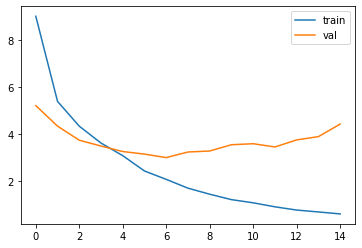

additionals_datasets,additional_dataset,lemming,word_vocab,word_vocab_size,word_embedding_dim,pos_vocab_dim,pos_embedding_dim,char_vocab_size,char_embedding_dim,num_classes,char_hidden_dims,char_lstm_layers,char_bidir,char_dropout,words_freeze,combined_hidden_dims,combined_lstm_layers,combined_bidir,combined_dropout,classificator_dropout,feature_dim_out,epochs,batch_size,learning_rate,weight_decay,char,cfr
['WNUT17.tsv', 'CoNLL.tsv'],True,False,glove-wiki-gigaword-300,400002,300,20,20,103,50,14,50,3,True,0.3,True,350,3,True,0.35,0.4,350,15,64,0.0005,0.0001,True,True


In [331]:
plt.plot(losses["train"], label="train")
plt.plot(losses["val"], label="val")
plt.legend()
plt.savefig(os.path.join(dir_path, "losses.png"))
plt.show()
print(params.csv)

with open(os.path.join(dir_path, "losses.csv"), "w") as f:
    values = "\n".join([str(x)+","+str(y) for x,y in zip(losses["train"], losses["val"])])
    f.write("train,val\n"+values)

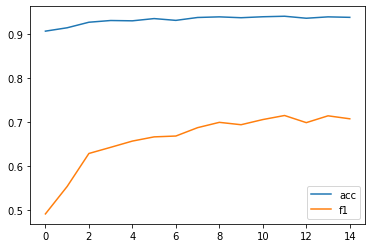

In [332]:
plt.plot(accs["val"], label="acc")
plt.plot(f1ns["val"], label="f1")
plt.legend()
plt.savefig(os.path.join(dir_path, "val.png"))
plt.show()

In [333]:
predictions_s = model.predict(dev_t)

181 unknown words found


In [334]:
print(seqeval.metrics.classification_report(dev_l, predictions_s))

              precision    recall  f1-score   support

        CORP       0.66      0.65      0.66       133
          CW       0.61      0.51      0.56       170
         GRP       0.77      0.75      0.76       190
         LOC       0.88      0.81      0.85       243
         PER       0.88      0.88      0.88       300
        PROD       0.60      0.50      0.54       149

   micro avg       0.77      0.72      0.74      1185
   macro avg       0.73      0.68      0.71      1185
weighted avg       0.77      0.72      0.74      1185



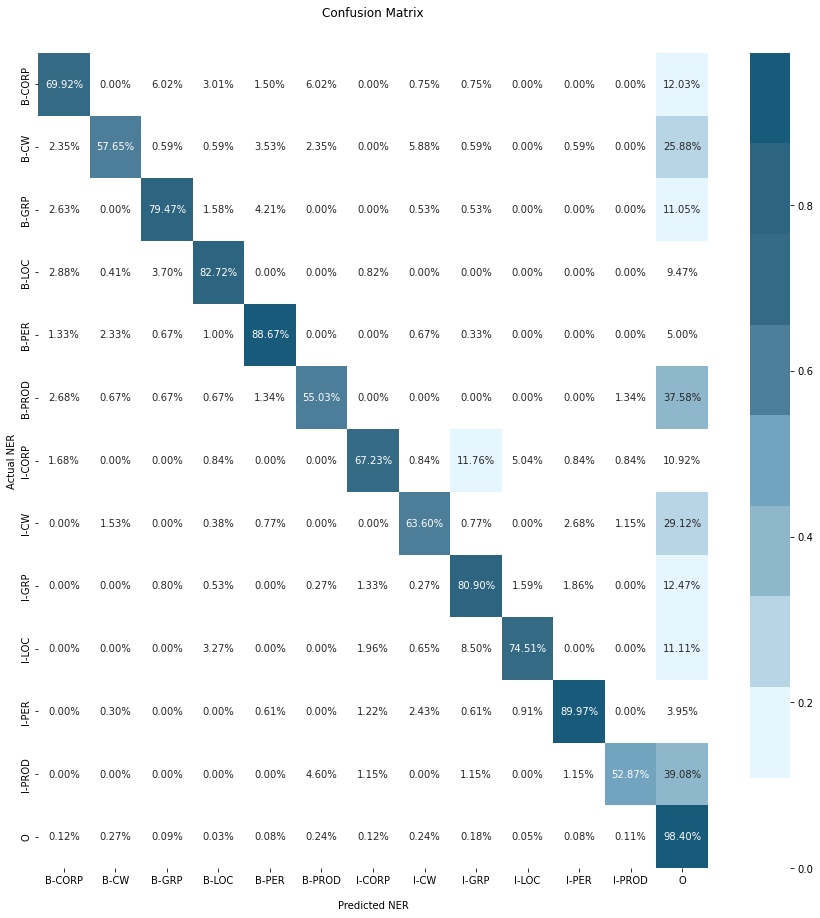

In [335]:
from sklearn.metrics import confusion_matrix
flat_label = [ x  for sentence in dev_l for x in sentence]
flat_predict = [ x  for sentence in predictions_s for x in sentence]
labels = [v for k,v in StudDataset.get_class_labels()][:-1]
cf_matrix = confusion_matrix(flat_label, flat_predict, labels=labels)
import seaborn as sns
import matplotlib.pyplot as plt

palette = ["#ffffff", "#e6f6ff", "#b8d5e6", "#8fb7cc", "#73a4bf", "#4d7e99", "#356a85","#2d6480" , "#185a7a", "#004c71"]


f, ax = plt.subplots(figsize=(15, 15))
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix, annot=True,
            fmt='.2%',
            cmap=sns.color_palette(palette, 9)
            )

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted NER')
ax.set_ylabel('Actual NER')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Display the visualization of the Confusion Matrix.
plt.savefig(os.path.join(dir_path, "conf_matrix.png"))
plt.show()

Save parameters

# Prediction Section

216 unknown words found
# accuracy: 0.9435
# f1: 0.7380
              precision    recall  f1-score   support

        CORP       0.75      0.78      0.76       193
          CW       0.57      0.53      0.55       174
         GRP       0.82      0.74      0.78       190
         LOC       0.83      0.87      0.85       234
         PER       0.88      0.92      0.90       290
        PROD       0.68      0.53      0.59       146

   micro avg       0.78      0.76      0.77      1227
   macro avg       0.75      0.73      0.74      1227
weighted avg       0.77      0.76      0.76      1227



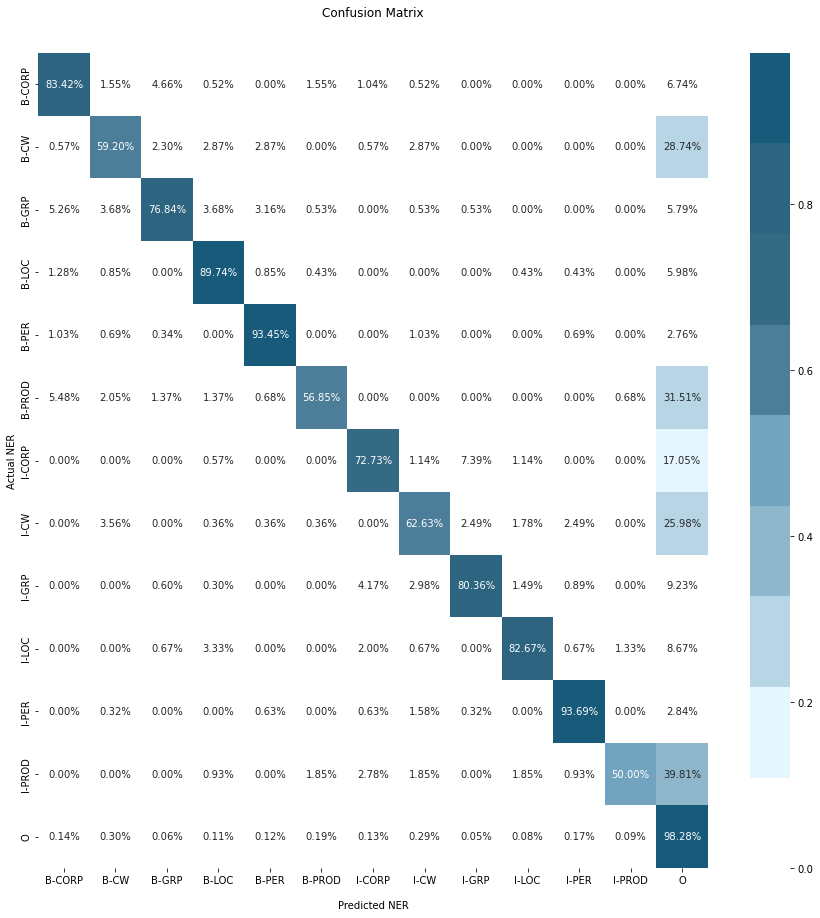

In [351]:
load = True
if load:
    ## Init Model

    params = StudParams()
    model = StudentModel_CoNLL(params).to(params.device)
    my_path = os.path.join(data_path, "boh.tsv")
    my_t, my_l = read_dataset(my_path)

    #my_t, my_l = dev_t, dev_l
    prediction_path = os.path.join(model_p, "predictions")
    model.load_state_dict(torch.load(os.path.join(model_p,"tests","71.54" ,"mid_loss_70.62_lower.ckpt")))
    predictions_s = model.predict(my_t)

    acc = accuracy_score(my_l, predictions_s)
    f = f1_score(my_l, predictions_s, average="macro")

    print(f"# accuracy: {acc:.4f}")
    print(f"# f1: {f:.4f}")
    prediction_path = os.path.join(model_p, "predictions")

    print(seqeval.metrics.classification_report(my_l, predictions_s))

    from sklearn.metrics import confusion_matrix
    flat_label = [ x  for sentence in my_l for x in sentence]
    flat_predict = [ x  for sentence in predictions_s for x in sentence]
    labels = [v for k,v in StudDataset.get_class_labels()][:-1]
    cf_matrix = confusion_matrix(flat_label, flat_predict, labels=labels)
    import seaborn as sns
    import matplotlib.pyplot as plt

    palette = ["#ffffff", "#e6f6ff", "#b8d5e6", "#8fb7cc", "#73a4bf", "#4d7e99", "#356a85","#2d6480" , "#185a7a", "#004c71"]


    f, ax = plt.subplots(figsize=(15, 15))
    cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix, annot=True,
                fmt='.2%',
                cmap=sns.color_palette(palette, 9)
                )

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted NER')
    ax.set_ylabel('Actual NER')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath(data)
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)